In [1]:
import pandas as pd
import numpy as np
import math
from glob import glob
from tqdm.notebook import tqdm
from utils import iter_df_read, get_array_diff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import datetime
from datetime import date
import scipy.stats as stats
import matplotlib.patheffects as pe

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Importación de datos

In [2]:
desertores_1 = pd.read_csv(f"{BASE}work_data/matriz_desercion_1.csv.gz")
desertores_1.head()

/tmp/ipykernel_13437/1681348878.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  desertores_1 = pd.read_csv(f"{BASE}work_data/matriz_desercion_1.csv.gz")


,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,region_sede,area_conocimiento,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Biobío,Tecnología,0.0,NaN,NaN,NaN,NaN
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Metropolitana,Administración y Comercio,0.0,13,310.0,4.975,3.0
2,2015,I106S3C64J4V1,253.0,1,198404,2015,Institutos Profesionales,Metropolitana,Administración y Comercio,1.0,NaN,NaN,NaN,NaN
3,2015,I221S1C57J1V1,370.0,2,198910,2015,Centros de Formación Técnica,Metropolitana,Administración y Comercio,1.0,13,310.0,5.100,3.0
4,2015,I176S8C59J2V1,533.0,2,198309,2015,Institutos Profesionales,Coquimbo,Salud,0.0,4,510.0,5.200,2.0


In [3]:
pass_columns = ["codigo_unico", "mrun", "fec_nac_alu", "prom_notas_media", "dependecia_colegio"]
for column in desertores_1.columns:
    if column in pass_columns:
        continue
    print(f"Columna: {column}")
    print()
    print(desertores_1[column].unique())
    print()
    print(90*"-")
    print()

Columna: cat_periodo

[2015 2016 2017 2018 2019 2020 2021]

------------------------------------------------------------------------------------------

Columna: gen_alu

[1 2]

------------------------------------------------------------------------------------------

Columna: anio_ing_carr_ori

[2015 2016 2017 2018 2019 2020 2021]

------------------------------------------------------------------------------------------

Columna: tipo_inst_1

['Centros de Formación Técnica' 'Institutos Profesionales']

------------------------------------------------------------------------------------------

Columna: region_sede

['Biobío' 'Metropolitana' 'Coquimbo' 'Antofagasta' 'Valparaíso'
 'Los Lagos' "Lib. Gral B. O'Higgins" 'Arica y Parinacota' 'La Araucanía'
 'Atacama' 'Los Ríos' 'Maule' 'Ñuble' 'Magallanes' 'Tarapacá' 'Aysén']

------------------------------------------------------------------------------------------

Columna: area_conocimiento

['Tecnología' 'Administración y Comercio' 'Sal

## Tipos de Enseñanza de los colegios

In [4]:
tipo_ensenanza_colegio = {  0: "No Aplica",
                           10: "Educación Parvularia",
                          110: "Enseñanza Básica",
                          160: "Educación Básica Común Adultos (Decreto 584/2007)",
                          161: "Educación Básica Especial Adultos",
                          163: "Escuelas Cárceles (Educación Adultos)",
                          165: "Educación Básica Adultos Sin Oficios (Decreto 584/2007)",
                          167: "Educación Básica Adultos Con Oficios (Decreto 584/2007 y 999/2009)",
                          211: "Educación Especial Discapacidad Auditiva",
                          212: "Educación Especial Discapacidad Intelectual",
                          213: "Educación Especial Discapacidad Visual",
                          214: "Educación Especial Trastornos Específicos del Lenguaje",
                          215: "Educación Especial Trastornos Motores",
                          216: "Educación Especial Autismo",
                          217: "Educación Especial Discapacidad Graves Alteraciones en la Capacidad de Relación y Comunicación",
                          299: "Opción 4 Programa Integración Escolar",
                          310: "Enseñanza Media H-C niños y jóvenes",
                          360: "Enseñanza Media H-C adultos vespertino y nocturno (Decreto N° 190/1975)",
                          361: "Enseñanza Media H-C adultos (Decreto N° 12/1987)",
                          362: "Escuelas Cárceles (Media Adulto)",
                          363: "Educación Media H-C Adultos (Decreto N° 1000/2009)",
                          410: "Enseñanza Media T-P Comercial Niños y Jóvenes",
                          460: "Educación Media T-P Comercial Adultos (Decreto N° 152/1989)",
                          461: "Educación Media T-P Comercial Adultos (Decreto N° 152/1989)",
                          463: "Educación Media T-P Comercial Adultos (Decreo N° 1000/2009)",
                          510: "Enseñanza Media T-P Industrial Niños y Jóvenes",
                          560: "Educación Media T-P Industrial Adultos (Decreto N° 152/1989)",
                          561: "Educación Media T-P Industrial Adultos (Decreto N° 152/1989)",
                          563: "Educación Media T-P Indsutrial Adultos (Decreo N° 1000/2009)",
                          610: "Enseñanza Media T-P Técnica Niños y Jóvenes",
                          660: "Educación Media T-P Técnica Adultos (Decreto N° 152/1989)",
                          661: "Educación Media T-P Técnica Adultos (Decreto N° 152/1989)",
                          663: "Educación Media T-P Técnica Adultos (Decreto N° 1000/1989)",
                          710: "Enseñanza Media T-P Agrícola Niños y Jóvenes",
                          760: "Educación Media T-P Agrícola Adultos (Decreto N° 152/1989)",
                          761: "Educación Media T-P Agrícola Adultos (Decreto N° 152/1989)",
                          763: "Educación Media T-P Agrícola Adultos (Decreto N° 1000/1989)",
                          810: "Enseñanza Media T-P Marítima Niños y Jóvenes",
                          860: "Enseñanza Media T-P Marítima Adultos (Decreto N° 152/1989)",
                          863: "Enseñanza Media T-P Marítima Adultos (Decreto N° 1000/1989)",
                          910: "Enseñanza Media Artística Niños y Jóvenes",
                          963: "Enseñanza Media Artística Adultos"
                         }

## Tipos de Enseñanza de los colegios en la base de datos

In [5]:
tipo_ensenanza_colegio_incluidos = {key: tipo_ensenanza_colegio[key] \
                                    for key in desertores_1["tipo_ensenanza_colegio"] if math.isnan(key) == False}

tipo_ensenanza_colegio_incluidos

{310.0: 'Enseñanza Media H-C niños y jóvenes',
 510.0: 'Enseñanza Media T-P Industrial Niños y Jóvenes',
 410.0: 'Enseñanza Media T-P Comercial Niños y Jóvenes',
 610.0: 'Enseñanza Media T-P Técnica Niños y Jóvenes',
 363.0: 'Educación Media H-C Adultos (Decreto N° 1000/2009)',
 563.0: 'Educación Media T-P Indsutrial Adultos (Decreo N° 1000/2009)',
 361.0: 'Enseñanza Media H-C adultos (Decreto N° 12/1987)',
 360.0: 'Enseñanza Media H-C adultos vespertino y nocturno (Decreto N° 190/1975)',
 710.0: 'Enseñanza Media T-P Agrícola Niños y Jóvenes',
 810.0: 'Enseñanza Media T-P Marítima Niños y Jóvenes',
 663.0: 'Educación Media T-P Técnica Adultos (Decreto N° 1000/1989)',
 463.0: 'Educación Media T-P Comercial Adultos (Decreo N° 1000/2009)',
 661.0: 'Educación Media T-P Técnica Adultos (Decreto N° 152/1989)',
 460.0: 'Educación Media T-P Comercial Adultos (Decreto N° 152/1989)',
 763.0: 'Educación Media T-P Agrícola Adultos (Decreto N° 1000/1989)',
 461.0: 'Educación Media T-P Comercial Adu

In [6]:
print("Cantidad de mrun duplicados")
print((desertores_1.pivot_table(columns=['mrun'], aggfunc='size') >= 1).sum())

Cantidad de mrun duplicados
1157169


In [7]:
# Se borran los duplciados
desertores_1 = desertores_1.sort_values(by=["mrun", "anio_ing_carr_ori"]).drop_duplicates(subset=["mrun"])

# Género

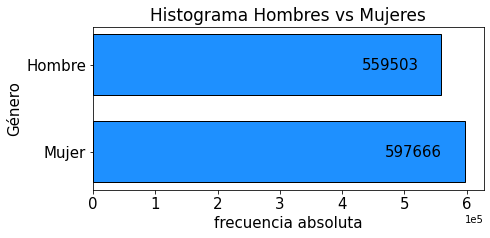

In [8]:
plt.figure(figsize=(7,3));
counts, edges, bars = plt.hist(desertores_1["gen_alu"].replace([1,2], ["Hombre", "Mujer"]),\
                               bins=[-.5,.5,1.5],\
                               ec="k",\
                               rwidth=0.7,
                               color="dodgerblue",
                               orientation='horizontal'); 
plt.bar_label(bars,size=15,padding=-80)
plt.title("Histograma Hombres vs Mujeres" ,size=17);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('frecuencia absoluta',size=15);
plt.ylabel("Género",size=15);
plt.tick_params(axis='both', which='major', labelsize=15)

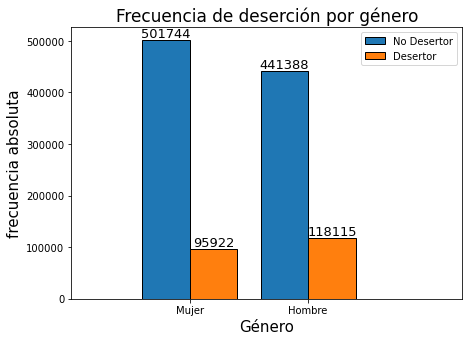

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
counts, edges, bars = ax.hist([desertores_1[desertores_1["desertor_1"]==0]["gen_alu"].replace([1,2], ["Hombre", "Mujer"]),\
                                desertores_1[desertores_1["desertor_1"]==1]["gen_alu"].replace([1,2], ["Hombre", "Mujer"])],\
                                bins=[-.5,.5,1.5], ec="k", label=["No Desertor", "Desertor"]); 

for b in bars:
    ax.bar_label(b,size=13)
    
plt.title("Frecuencia de deserción por género" ,size=17);
plt.ylabel('frecuencia absoluta',size=15);
plt.xlabel("Género",size=15);
plt.xlim([-1,2.3])
plt.legend();

desertor_1,0.0,1.0
gen_alu,,
1,441388,118115
2,501744,95922


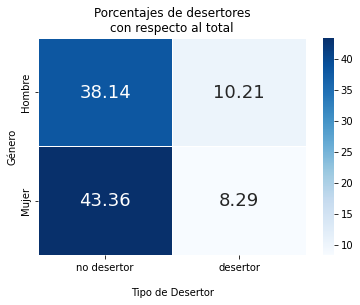

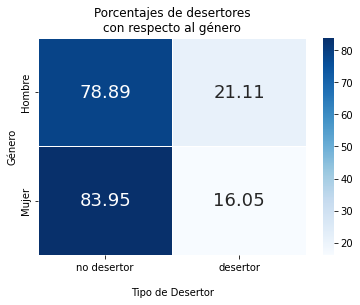

In [12]:
desertores_1_count_gen_des = pd.crosstab(desertores_1["gen_alu"], desertores_1["desertor_1"])

display(desertores_1_count_gen_des)


sns.heatmap(desertores_1_count_gen_des.div(np.sum(np.sum(desertores_1_count_gen_des)))\
                                 .mul(100)\
                                 .round(2), 
                                  cmap="Blues", 
                                  annot=True, 
                                  fmt=".2f", 
                                  linewidth=1,
                                  xticklabels=["no desertor", "desertor"], 
                                  yticklabels=["Hombre", "Mujer"],
                                  annot_kws={"fontsize":18})
plt.ylabel("Género");
plt.xlabel("\nTipo de Desertor");
plt.title("Porcentajes de desertores\ncon respecto al total");
plt.show()

sns.heatmap(desertores_1_count_gen_des.div(np.sum(desertores_1_count_gen_des.to_numpy(),axis=1), axis='rows')\
                                 .mul(100)\
                                 .round(2), 
                                  cmap="Blues", 
                                  annot=True, 
                                  fmt=".2f", 
                                  linewidth=1,
                                  xticklabels=["no desertor", "desertor"], 
                                  yticklabels=["Hombre", "Mujer"],
                                  annot_kws={"fontsize":18})
plt.ylabel("Género");
plt.xlabel("\nTipo de Desertor");
plt.title("Porcentajes de desertores\ncon respecto al género");
plt.show()

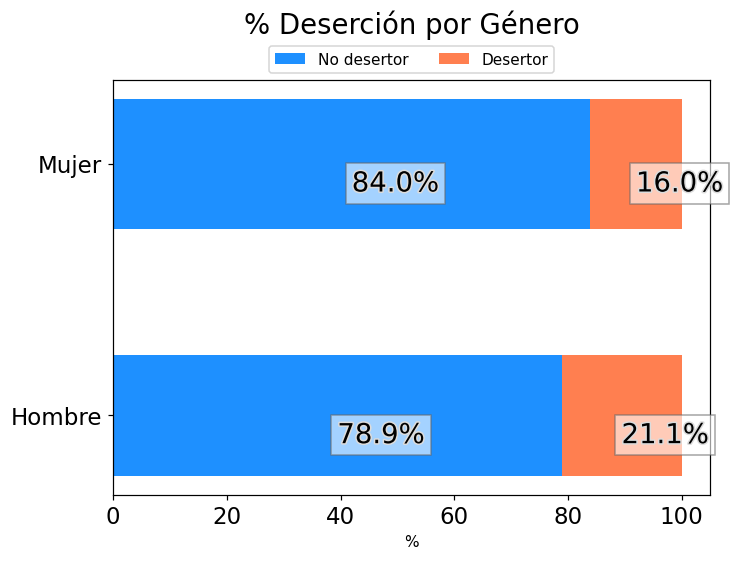

In [14]:
desertores_1["gen_alu_trans"] = desertores_1["gen_alu"].replace([1,2], ["Hombre", "Mujer"])

cross_tab_prop = pd.crosstab(desertores_1["gen_alu_trans"],
                             desertores_1["desertor_1"],
                             normalize="index")

cross_tab = pd.crosstab(desertores_1["gen_alu_trans"],
                        desertores_1["desertor_1"])


w = list(cross_tab.T.sum()/cross_tab.T.sum().sum())

f, ax = plt.subplots(figsize=(7,5), dpi=110)

plt.title("% Deserción por Género", fontsize=18, pad=30)

b1 = plt.barh(cross_tab_prop.reset_index()['gen_alu_trans'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['gen_alu_trans'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)

ax.legend(['No desertor', 'Desertor'],loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        t = plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=18,
                path_effects=[pe.withStroke(linewidth=2, foreground="gainsboro")])
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='dimgray'))

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(np.arange(0, 1.2, 0.2), [0, 20, 40, 60, 80, 100]);
ax.set_xlabel("%");
plt.show()

## Correlación con deserción

Usamos tetrachoric correlation (https://www.statology.org/tetrachoric-correlation/)

In [15]:
def tetrachoric_correlation(df_double_count):
    
    row_names = list(df_double_count.index)
    col_names = list(df_double_count.columns)
    
    a = df_double_count[col_names[0]][row_names[0]]
    b = df_double_count[col_names[1]][row_names[0]]
    c = df_double_count[col_names[0]][row_names[1]]
    d = df_double_count[col_names[1]][row_names[1]]
    
    return np.cos(np.pi/(1+(np.sqrt(a*d/b/c))))

In [16]:
tetrachoric_correlation(desertores_1_count_gen_des)

-0.13136932730395842

# Edad

19000101: valor por defecto (sin información)

In [17]:
no_inf_values = (desertores_1["fec_nac_alu"]==19000101).sum()
print(f"Valores sin información (19000101): {no_inf_values}")
print()

no_inf_values = (desertores_1["fec_nac_alu"]==190001).sum()
print(f"Valores sin información (190001): {no_inf_values}")
print()

print(f"Cantidad de nulos: \n{desertores_1.isna().sum()}")
print()

desertores_1 = desertores_1[desertores_1["fec_nac_alu"]!=190001]
no_inf_values = (desertores_1["fec_nac_alu"]==190001).sum()
print(f"Valores sin información (190001): {no_inf_values}")
print()

Valores sin información (19000101): 0

Valores sin información (190001): 27

Cantidad de nulos: 
cat_periodo                    0
codigo_unico                   0
mrun                           0
gen_alu                        0
fec_nac_alu                    0
anio_ing_carr_ori              0
tipo_inst_1                    0
region_sede                    0
area_conocimiento              0
desertor_1                     0
region_colegio            160586
tipo_ensenanza_colegio    160586
prom_notas_media          160586
dependencia_colegio       164245
gen_alu_trans                  0
dtype: int64

Valores sin información (190001): 0



In [18]:
# pasar int a tipo fecha
int2date = lambda x: datetime.date(x//100, x-100*(x//100), 1)

#calcular edad
def edad(df):
    anio_ing_carr_ori = df["anio_ing_carr_ori"]
    fec_nac = df["fec_nac_alu"]
    
    return datetime.date(anio_ing_carr_ori,1,1).year - int2date(fec_nac).year \
                        - (datetime.date(anio_ing_carr_ori,1,1).month < int2date(fec_nac).month)

desertores_1["edad"] = desertores_1.apply(lambda row: edad(row), axis=1)

desertores_1.head()

,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,region_sede,area_conocimiento,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio,gen_alu_trans,edad
1326628,2019,I536S0C39J1V1,19.0,2,199909,2019,Centros de Formación Técnica,Arica y Parinacota,Salud,0.0,15,610.0,5.625,3,Mujer,19
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Biobío,Tecnología,0.0,NaN,NaN,NaN,NaN,Hombre,36
2263365,2021,I111S22C8J1V1,98.0,2,200212,2021,Institutos Profesionales,Metropolitana,Administración y Comercio,0.0,13,310.0,4.775,3,Mujer,18
2263366,2021,I111S12C420J1V1,99.0,1,200301,2021,Institutos Profesionales,Metropolitana,Ciencias Básicas,0.0,13,510.0,6.525,5,Hombre,18
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Metropolitana,Administración y Comercio,0.0,13,310.0,4.975,3.0,Hombre,23


In [25]:
desertores_1["rango_edad"] = pd.cut(desertores_1["edad"], bins=[14,19,24,29,34,39,200],
                                    labels= ["15-19","20-24","25-29","30-34", \
                                             "35-39", "40 o más"])
desertores_1.head()

,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,region_sede,area_conocimiento,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio,gen_alu_trans,edad,rango_edad
1326628,2019,I536S0C39J1V1,19.0,2,199909,2019,Centros de Formación Técnica,Arica y Parinacota,Salud,0.0,15,610.0,5.625,3,Mujer,19,15-19
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Biobío,Tecnología,0.0,NaN,NaN,NaN,NaN,Hombre,36,35-39
2263365,2021,I111S22C8J1V1,98.0,2,200212,2021,Institutos Profesionales,Metropolitana,Administración y Comercio,0.0,13,310.0,4.775,3,Mujer,18,15-19
2263366,2021,I111S12C420J1V1,99.0,1,200301,2021,Institutos Profesionales,Metropolitana,Ciencias Básicas,0.0,13,510.0,6.525,5,Hombre,18,15-19
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Metropolitana,Administración y Comercio,0.0,13,310.0,4.975,3.0,Hombre,23,20-24


### Histograma usando la variable continua de edad

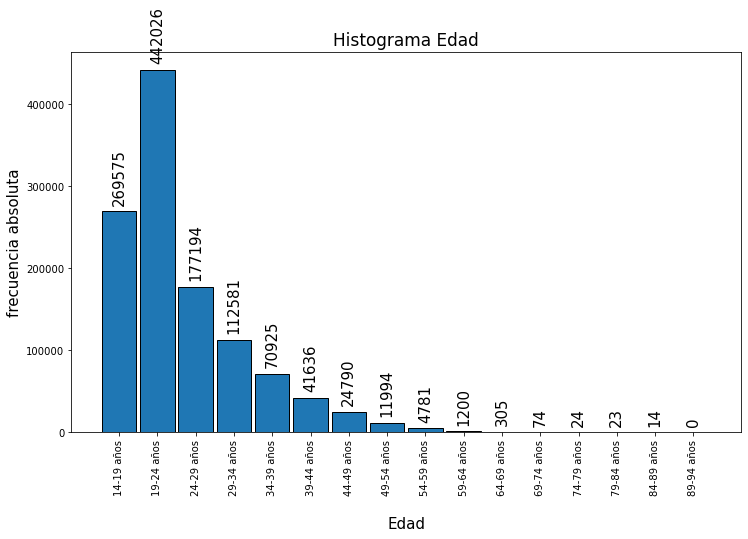

In [26]:
plt.figure(figsize=(12,7));
bins = [14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94]
counts, edges, bars = plt.hist(desertores_1["edad"],\
                               bins=bins,\
                               ec="k",\
                               rwidth=0.9); 
plt.bar_label(bars,size=15,padding=6, rotation=90)
plt.title("Histograma Edad" ,size=17);
plt.ylabel('frecuencia absoluta',size=15);
plt.xlabel("\nEdad",size=15);

ticks = [bins[i-1]+(bins[i]-bins[i-1])/2 for i in range(1,len(bins))]
labels = [f"{bins[i-1]}-{bins[i]} años" for i in range(1,len(bins))]
plt.xticks(ticks, labels,rotation = 90);


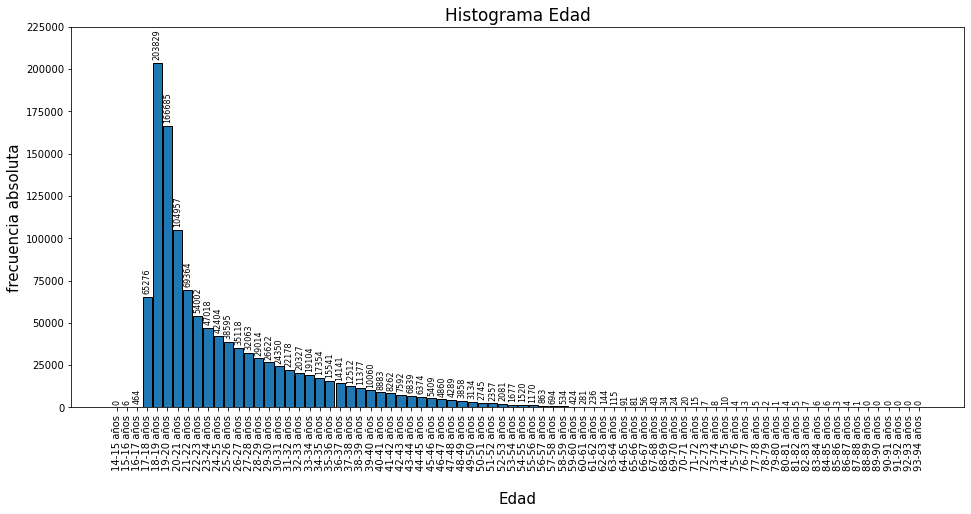

In [27]:
plt.figure(figsize=(16,7));
bins = np.arange(14,95,1)
counts, edges, bars = plt.hist(desertores_1["edad"],\
                               bins=bins,\
                               ec="k",\
                               rwidth=0.9); 
plt.bar_label(bars,size=8,padding=3, rotation=90)
plt.title("Histograma Edad" ,size=17);
plt.ylabel('frecuencia absoluta',size=15);
plt.xlabel("\nEdad",size=15);
plt.ylim([0,225000])

ticks = [bins[i-1]+(bins[i]-bins[i-1])/2 for i in range(1,len(bins))]
labels = [f"{bins[i-1]}-{bins[i]} años" for i in range(1,len(bins))]
plt.xticks(ticks, labels,rotation = 90);

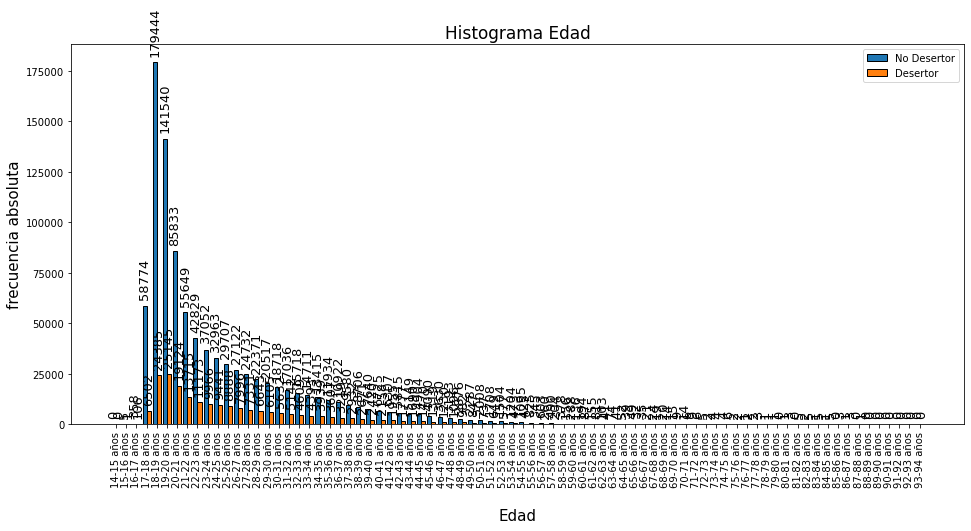

In [28]:
fig, ax = plt.subplots(figsize=(16,7))
counts, edges, bars = ax.hist([desertores_1[desertores_1["desertor_1"]==0]["edad"],\
                               desertores_1[desertores_1["desertor_1"]==1]["edad"]],\
                                bins=bins, ec="k", label=["No Desertor", "Desertor"]); 

for b in bars:
    ax.bar_label(b,size=13,padding=6, rotation=90)
plt.title("Histograma Edad" ,size=17);
plt.ylabel('frecuencia absoluta',size=15);
plt.xlabel("\nEdad",size=15);
plt.legend()
plt.xticks(ticks, labels,rotation = 90);

### Histograma usando el rango de edad

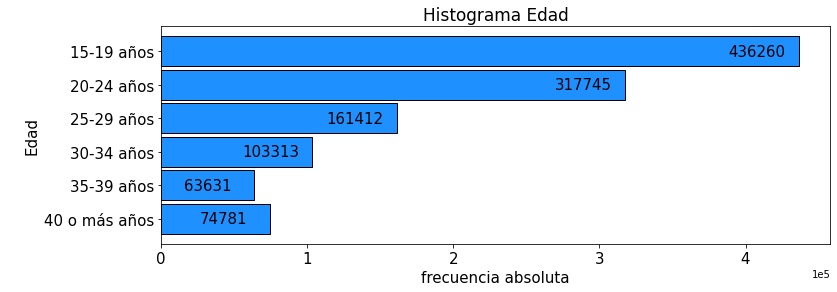

In [29]:
plt.figure(figsize=(12,4));
#bins = [14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94]
counts, edges, bars = plt.hist(desertores_1["rango_edad"].dropna().sort_values(ascending=False),\
                               bins=6,\
                               ec="k",\
                               rwidth=0.9,
                               color = "dodgerblue",
                               orientation='horizontal'); 
plt.bar_label(bars,size=15,padding=-70)
plt.title("Histograma Edad" ,size=17);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('frecuencia absoluta',size=15);
plt.ylabel("\nEdad",size=15);


ticks = [edges[i-1]+(edges[i]-edges[i-1])/2 for i in range(1,len(edges))]
labels = ["40 o más años", "35-39 años", "30-34 años", "25-29 años", "20-24 años","15-19 años"]
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yticks(ticks, labels);

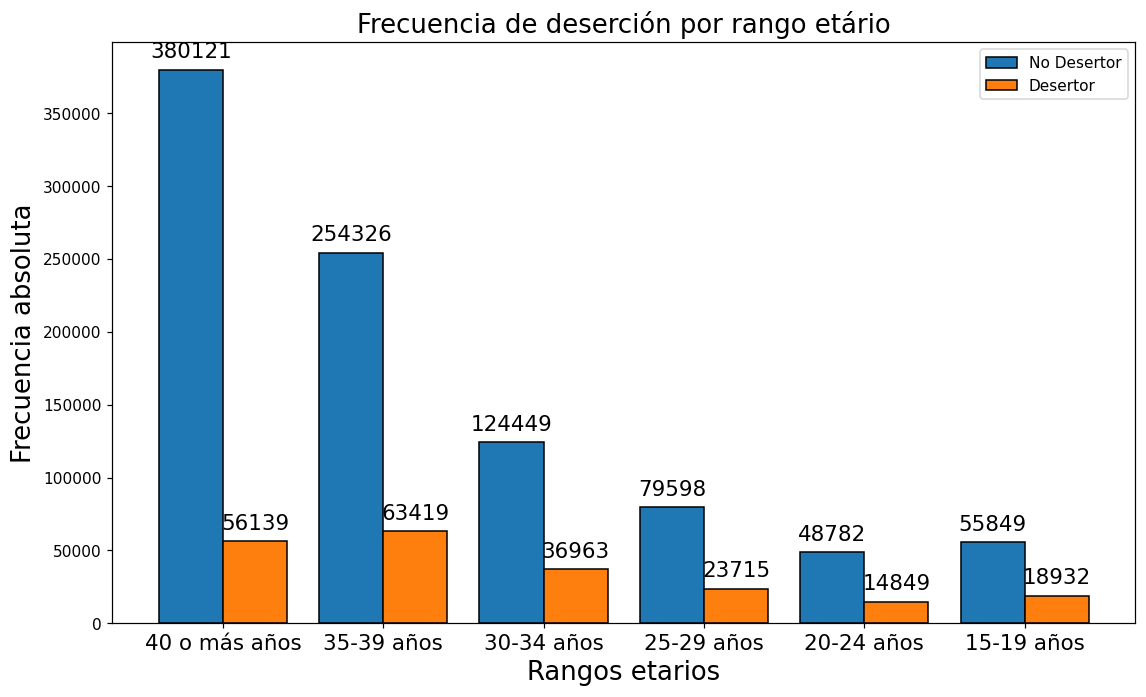

In [39]:
fig, ax = plt.subplots(figsize=(12,7), dpi=110)
counts, edges, bars = ax.hist([desertores_1[desertores_1["desertor_1"]==0]["rango_edad"].dropna().sort_values(),\
                               desertores_1[desertores_1["desertor_1"]==1]["rango_edad"].dropna().sort_values()],\
                                bins=6, ec="k", label=["No Desertor", "Desertor"]); 

for b in bars:
    ax.bar_label(b,size=14,padding=5, rotation=0)
plt.title("Frecuencia de deserción por rango etário" ,size=17);
plt.ylabel('Frecuencia absoluta',size=17);
plt.xlabel("Rangos etarios",size=17);
plt.xticks(ticks, labels,rotation = 0, fontsize=14);
plt.legend();

desertor_1,0.0,1.0
rango_edad,,
15-19 años,380121,56139
20-24 años,254326,63419
25-29 años,124449,36963
30-34 años,79598,23715
35-39 años,48782,14849
40 o más años,55849,18932


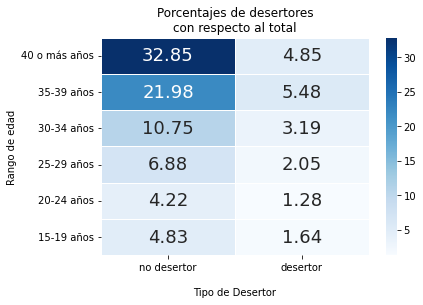

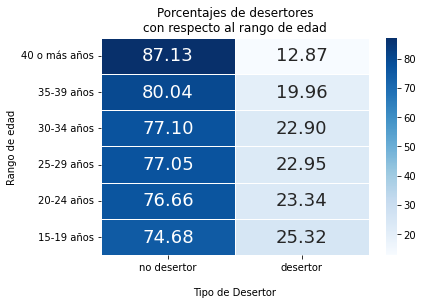

In [26]:
desertores_1_count_rango_edad_des = pd.crosstab(desertores_1["rango_edad"], desertores_1["desertor_1"])

display(desertores_1_count_rango_edad_des)

sns.heatmap(desertores_1_count_rango_edad_des.div(np.sum(np.sum(desertores_1_count_rango_edad_des)))\
                                 .mul(100)\
                                 .round(2), 
                                  cmap="Blues", 
                                  annot=True, 
                                  fmt=".2f", 
                                  linewidth=1,
                                  xticklabels=["no desertor", "desertor"], 
                                  yticklabels=labels,
                                  annot_kws={"fontsize":18})
plt.ylabel("Rango de edad");
plt.xlabel("\nTipo de Desertor");
plt.title("Porcentajes de desertores\ncon respecto al total");
plt.show()

sns.heatmap(desertores_1_count_rango_edad_des.div(np.sum(desertores_1_count_rango_edad_des.to_numpy(),axis=1), axis='rows')\
                                 .mul(100)\
                                 .round(2), 
                                  cmap="Blues", 
                                  annot=True, 
                                  fmt=".2f", 
                                  linewidth=1,
                                  xticklabels=["no desertor", "desertor"], 
                                  yticklabels=labels,
                                  annot_kws={"fontsize":18})
plt.ylabel("Rango de edad");
plt.xlabel("\nTipo de Desertor");
plt.title("Porcentajes de desertores\ncon respecto al rango de edad");
plt.show()

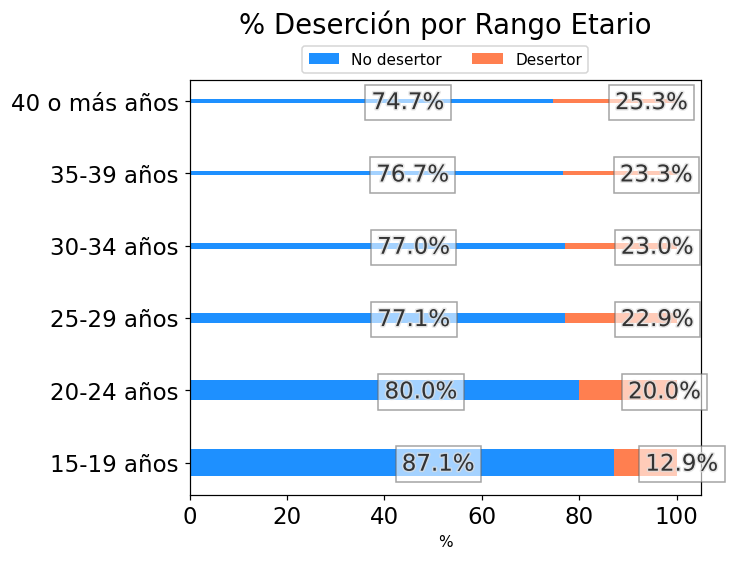

In [87]:
cross_tab_prop = pd.crosstab(desertores_1["rango_edad"],
                             desertores_1["desertor_1"],
                             normalize="index")

cross_tab = pd.crosstab(desertores_1["rango_edad"],
                        desertores_1["desertor_1"])


w = list(cross_tab.T.sum()/cross_tab.T.sum().sum())

f, ax = plt.subplots(figsize=(6,5), dpi=110)

plt.title("% Deserción por Rango Etario", fontsize=18, pad=30)

b1 = plt.barh(cross_tab_prop.reset_index()['rango_edad'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['rango_edad'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)

ax.legend(['No desertor', 'Desertor'],loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        t = plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 alpha=0.7,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=15,
                path_effects=[pe.withStroke(linewidth=2, foreground="gainsboro")])
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='dimgray'))
        
ax.tick_params(axis='both', which='major', labelsize=15)   
ax.set_xticks(np.arange(0, 1.2, 0.2), [0, 20, 40, 60, 80, 100]);
ax.set_xlabel("%");
plt.show()

## Correlación con deserción

Usamos Cramer's V correlation (https://www.geeksforgeeks.org/how-to-calculate-cramers-v-in-python/)

In [28]:
def cramers_v_correlation(df_count):  
    X2 = stats.chi2_contingency(df_count, correction=False)[0]
    N = np.sum(np.sum(df_count))
    minimum_dimension = min(df_count.shape)-1
    
    return np.sqrt((X2/N) / minimum_dimension)

In [29]:
cramers_v_correlation(desertores_1_count_rango_edad_des)

0.11887751273313392

# Otras referencia para calcular correlación

https://www.statology.org/correlation-between-categorical-variables/

# Bi variado